In [1]:
import numpy as np
from scipy import io
from scipy import sparse
from scipy.sparse import csgraph
from scipy import fftpack
from scipy import signal
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import collections
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns
import igraph

import graph3d

%matplotlib inline

In [2]:
sns.set_palette('husl')

# Signal smoothness with respect to graph structure

In [3]:
# Define a ring graph
n = 100
Aring = np.roll(np.eye(n), -1, axis=1) + np.roll(np.eye(n), 1, axis=1)

# Define a signal over the ring graph
f = np.sin(np.linspace(-8*np.pi, 8*np.pi, n))

In [4]:
# Generate coords for plotting
x = np.cos(np.linspace(-2*np.pi, 2*np.pi, n))
y = np.sin(np.linspace(-2*np.pi, 2*np.pi, n))
xy = np.column_stack([x, y])
startcoords = xy[np.where(Aring)[0]]
endcoords = xy[np.where(Aring)[1]]
Aring_lines = [[tuple(x), tuple(y)] for x, y in zip(startcoords, endcoords)]

In [5]:
Acrossed = Aring.copy()

# Randomly connect 40 vertices of the ring
s = np.random.randint(0, len(Aring), 40)
e = np.random.randint(0, len(Aring), 40)
for i, j in zip(s, e):
    Acrossed[i, j] = 1
    Acrossed[j, i] = 1

# Regenerate coords for plotting
startcoords = xy[np.where(Acrossed)[0]]
endcoords = xy[np.where(Acrossed)[1]]
Acrossed_lines = [[tuple(x), tuple(y)] for x, y in zip(startcoords, endcoords)]

In [6]:
# Compute laplacian eigendecompositions
Lring = csgraph.laplacian(Aring)
lring, uring = linalg.eigh(Lring)
Lcrossed = csgraph.laplacian(Acrossed)
lcrossed, ucrossed = linalg.eigh(Lcrossed)

In [7]:
# Compute graph Fourier transform of signals
fhat_ring = np.conj(uring.T) @ f
fhat_crossed = np.conj(ucrossed.T) @ f

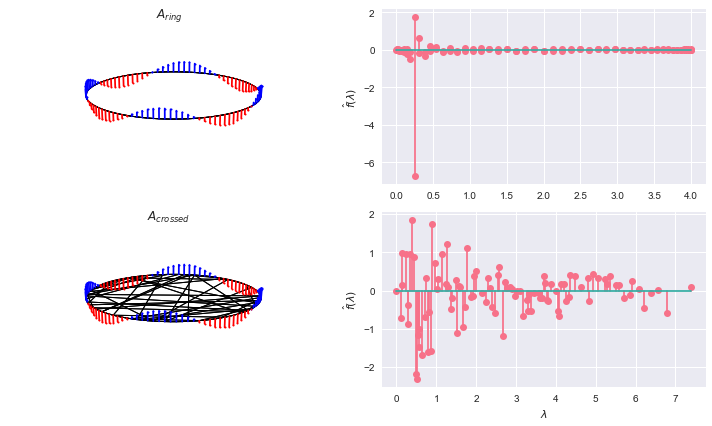

In [8]:
# Plot frequency spectrum for ring and crossed ring
fig = plt.figure(figsize=(10,6))

lc = collections.LineCollection(Aring_lines, linewidths=1, colors='k')
ax0 = fig.add_subplot(2, 2, 1, projection='3d')
graph3d.Graph3d(xy[:,0], xy[:,1], f, zmin=-4, zmax=4, fig=fig, ax=ax0, lc=lc)
ax0.set_title(r'$A_{ring}$')

lc = collections.LineCollection(Acrossed_lines, linewidths=1, colors='k')
ax1 = fig.add_subplot(2, 2, 3, projection='3d')
graph3d.Graph3d(xy[:,0], xy[:,1], f, zmin=-4, zmax=4, fig=fig, ax=ax1, lc=lc)
ax1.set_title(r'$A_{crossed}$')

ax2 = fig.add_subplot(2, 2, 2)
ax2.stem(lring, fhat_ring)
ax2.set_ylabel(r'$\hat{f}(\lambda)$')

ax4 = fig.add_subplot(2, 2, 4)
ax4.stem(lcrossed, fhat_crossed)
ax4.set_ylabel(r'$\hat{f}(\lambda)$')
ax4.set_xlabel(r'$\lambda$')

plt.tight_layout()
plt.savefig('../img/signal_smoothness_0.pdf', bbox_inches='tight')

# Local metrics of smoothness

#### The edge derivative of $f$ with respect to edge $e=(i,j)$

\begin{equation}
      \frac{\partial f}{\partial e} \bigg|_i = \sqrt{W_{i,j}} [f(j) - f(i)]
\end{equation}

  The local variation can be measured by the square root of the sum of the squared differences
  between signal values at adjacent vertices.
  
#### The graph gradient of $f$ at vertex $i$

\begin{equation}
    || \nabla_i f || = \bigg[ \bigg\{ \frac{\partial f}{\partial e} \bigg|_i \bigg\} \bigg|_{e \in \epsilon \ s.t. \ e=(i,j) \text{ for some } j \in V} \bigg]
\end{equation}

  
#### The local variation at vertex $i$
\begin{equation}
      || \nabla_i f ||_2 = \bigg[ \sum_{\text{e connected to i}} \bigg( \frac{\partial f}{\partial e} \bigg|_i \bigg)^2 \bigg]^{1/2} = \bigg[ \sum_{j \in N_i} W_{i,j} [f(j) - f(i)]^2 \bigg]^{1/2}
\end{equation}

In [9]:
def graph_gradient(A, f, i):
    # j : unique neighbors of i (possibly asymmetrical)
    j = np.unique(np.concatenate([np.where(A[i, :])[0],
                                  np.where(A[:, i])[0]]))
    return A[i, j]*(f[i] - f[j])

In [10]:
graph_gradient(Aring, f, 50)

array([ 0.50229597, -0.43893102])

In [11]:
def local_variation(A, f, i):
    local_var = np.sqrt(np.sum(graph_gradient(A, f, i)**2))
    return local_var

In [12]:
local_variation(Aring, f, 50)

0.66705448799508404

# Global metrics of smoothness

#### Discrete p-Dirichlet form of $f$
\begin{equation}
   S_p(f) = \frac{1}{p} \sum_{i \in V} \bigg[ \sum_{j \in N_i} W_{i,j} [f(j) - f(i)]^2 \bigg]^{\frac{p}{2}}
\end{equation}

For $p=1$, $S_1$ is simply the sum of local variations across all vertices.

For $p=2$, $S_2$ is a quadratic function of the Laplacian:

#### Graph Laplacian Quadratic Form
\begin{equation}
  \begin{split}
    S_2(f) = \frac{1}{2} \sum_{i \in V} \bigg[ \sum_{j \in N_i} W_{i,j}
        [f(j) - f(i)]^2 \bigg]^{\frac{1}{2}} = \sum_{(i, j) \in \epsilon}
        W_{i,j} [f(j) - f(i)]^2 \\
        = f^T L f
  \end{split}
\end{equation}

$S_2$ is small when $f$ has similar values at strongly-connected vertices.


In [13]:
def dirichlet_p(A, f, p=2):
    i, j = np.where(A)
    return (1/p)*np.sum((A[i, j]*(f[i] - f[j])**2)**(p/2))

In [14]:
def quad_laplace(L, f):
    return f @ L @ f

In [15]:
# Is the dirichlet p form equivalent to the quadratic form?
dirichlet_ring = dirichlet_p(Aring, f, p=2)
quadratic_ring = quad_laplace(Lring, f)
np.isclose(dirichlet_ring, quadratic_ring)

True

In [16]:
dirichlet_crossed = dirichlet_p(Acrossed, f, p=2)
quadratic_crossed = quad_laplace(Lcrossed, f)
np.isclose(dirichlet_crossed, quadratic_crossed)

True

In [17]:
print('Graph laplacian quadratic form:')
print('\n')
print(r'Ring:         ', f @ Lring @ f)
print(r'Crossed ring: ', f @ Lcrossed @ f)

Graph laplacian quadratic form:


Ring:          12.4889116701
Crossed ring:  56.6338735435
